In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import os
from PIL import Image
import copy
import scipy.io

import os         
os.sys.path.insert(0, '/home/dwang/Projects/MotorImagery_3D/BrainDecode_Library/models')

In [3]:
# 来得出每个test参与者的平均heatmap
Test_participant_Num = 66 # 65 ~74

# 1. Load Pretrained Model

In [4]:
from deep4_3D_3 import MotioNet_3D

model = MotioNet_3D().create_network()

- As shown above, we instantiate an MotioNet object and use it as a 'container'. It is a framework which can be used to 'contain' the trained params.
- As I said, the instantiated object is only a framework. It has all the hyperparams which are used to define the network. But it doesn't have any trained params.
- So we use the command below to load the trained params.

In [5]:
model.load_state_dict(torch.load('Trained_Motion_Detection_3DCNN'))

model.eval()
#  when you load the model back again via state_dict method, remember to do MyModel.eval(), 
# otherwise the results will differ. 
#  https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610/12

# since we only need to feed the test dataset to the model, so I think model.eval should be fine.

Sequential(
  (dimshuffle): Expression(expression=<lambda>)
  (To_3D): Expression(expression=<lambda>)
  (Conv3D_1_1): Conv3d (1, 10, kernel_size=(5, 2, 2), stride=(1, 1, 1), bias=False)
  (Bnorm3D_1_1): BatchNorm3d(10, eps=1e-05, momentum=0.1, affine=True)
  (3D_nonlin_1_1): Expression(expression=elu)
  (Conv3D_1_2): Conv3d (10, 20, kernel_size=(10, 2, 2), stride=(1, 1, 1), bias=False)
  (Bnorm3D_1_2): BatchNorm3d(20, eps=1e-05, momentum=0.1, affine=True)
  (3D_nonlin_1_2): Expression(expression=elu)
  (Conv3D_1_3): Conv3d (20, 30, kernel_size=(1, 3, 7), stride=(1, 1, 1), bias=False)
  (Bnorm3D_1_3): BatchNorm3d(30, eps=1e-05, momentum=0.1, affine=True)
  (3D_nonlin_1_3): Expression(expression=elu)
  (squeeze_1): Expression(expression=squeeze_layer1_output)
  (pool): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), dilation=(1, 1))
  (pool_nonlin): Expression(expression=identity)
  (drop_2): Dropout(p=0.5)
  (conv_2): Conv2d (30, 50, kernel_size=(10, 1), stride=(1, 1), dilation=(2, 1), bi

In [6]:
#model.Bnorm3D_1_3.running_mean

**You can double check the loaded model is the trained model**

# 2. Redefine Network Module Classes with RelProp

## 2.1 Convolution Layer

<img src="Figures_for_Notebook\EEG_LRP_Paper.png">

- W doesn't have to be positive.
- Z has the chance to be negative, so does the relevance.
- negative relevance can be projected to the input space.  
  
Additional Comments:  
- Without the limitation that W has to be positive, the system makes more sense. Because the sum of positive Z+ in layer L is not the real 'impact' to the next neuron. To consider the real impact to the next neuron, we need to sum all the Z in layer L, no matter whether it is positive or not.
  
- For negative Z-, it means the corresponding neuron makes contribution (object the decision).
  
- If the total contribution is 46(STAI), then... ,  for a neuron in layer L+1, R=12. It needs to distribute R to neurons in Layer l, according to the 'contritbuion rates' of neurons, e.g., 80%, 35%, -15%. -15% means the nueron's feature tries to 'drag down' the STAI score. It is an anti-anxiety evidence. 

- So, we can interpret LRP values as positive related or negative related.

### 2.1.1 Convolution 2-D 

In [7]:
class Conv2D_layer(nn.Conv2d):      # Inherit Official Class 'nn.Conv2d'
    def __init__(self, conv2d_module):
        # First, initializing the based class 'nn.Conv2d'
        super(nn.Conv2d, self).__init__(conv2d_module.in_channels,  #  give the params of a certain 2d-Conv in 
                                        conv2d_module.out_channels, # MotioNet to this Module
                                        conv2d_module.kernel_size, 
                                        conv2d_module.stride, 
                                        conv2d_module.padding, 
                                        conv2d_module.dilation,
                                        conv2d_module.transposed,
                                        conv2d_module.output_padding,
                                        conv2d_module.groups,
                                        False)                      # 除了最后输出的卷积层用了bias，其他的都没有用
        # Check: https://pytorch.org/docs/stable/_modules/torch/nn/modules/conv.html#Conv2d 
        # for init param settings
        
        self.weight = conv2d_module.weight # We are not just define a CONV layer, we also set the trained weights
        # 这里的初始化是否正确？上述赋值的顺序有没有写反？我觉得没有，因为我们在前向运算中得到了正确的结果。
        
    def gradprop(self, DY):
        # 考虑到dilation对kernel_size的影响。（见测试3）
        kernel_size_H = self.kernel_size[0] + (self.dilation[0] - 1)*(self.kernel_size[0] - 1)
        kernel_size_W = self.kernel_size[1] + (self.dilation[1] - 1)*(self.kernel_size[1] - 1)
        
        output_padding_H = self.X.size()[2] - ((self.Y.size()[2] - 1) * self.stride[0] 
                                               - 2 * self.padding[0] + kernel_size_H)
        output_padding_W = self.X.size()[3] - ((self.Y.size()[3] - 1) * self.stride[1] 
                                               - 2 * self.padding[1] + kernel_size_W)        
        # https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d
        # output_padding就是由这个网页中的公式推导出的，需要注意的是，在公式中：
        # self.X shape: (N,Cin,Hin,Win)
        # self.Y shape: (N,Cout,Hout,Wout)
        # in 指的是反卷积函数的 in，也就是我们卷积的输出！out 指的是反卷积的 out, 也就是我们的卷积的输入！
        
        # 其实，反卷积函数是如何利用卷积的信息、output_padding的信息来求解反卷积的，我是不知道的。
        # 我只能尽量保证提供给反卷积函数的信息是正确的
        
        # 我不清楚dilation对kernel_size的影响是否应该反应到kernel_size中，因为在反卷积函数中已经包含了dilation的信息
        # 所以，我们需要做个小实验（测试3）。实验结果表明，即使在反卷积函数中输入dilation，我们还是要留意output_padding中的
        # kernel_size，确保其考虑了dilation。这在文档中没有提到，我不清楚是否正确？
        
        return F.conv_transpose2d(DY, 
                                  self.weight, 
                                  stride=self.stride, 
                                  padding=self.padding,
                                  dilation=self.dilation,  # 需要了解卷积的信息，才能进行反卷积
                                  output_padding=(output_padding_H,output_padding_W),
                                  # 如果利用常规信息进行的反卷积的shape与卷积输入的不相符，output_padding会补0。
                                  groups=self.groups
                                 )
    # 经过我们的理解，可以得知 “ LRP的第三步实现 = 梯度方向传播 = 反卷积 ”
    
    # 以下四步是经典的LRP实现方法。LRP的实现步骤和我们的分块理解是不同的。因为实现步骤中借用了gradprop来对实现进行了简化。
    def relprop(self,R): # follow the Rule above. It is not Z+ or Z+B rule, we can have negative relationship.
        # We don't need to copy the layer nor only keep the W+, not at all.
        Z = self.Y+1e-9; 
        S = R/Z
        C = self.gradprop(S);         
        R = self.X*C
        
        return R

In [8]:
# 其实这个class和上面的Conv2D_layer基本一致，唯一不同的是 bias = True。
# 因为在AnxietyDecoder中，我们默认所有的卷积层的bias都是为0的，但是，在我们的MotioNet中，最后一个卷积层Conv_classifier的bias不是0！
# 就是因为这么一个 bias，导致我们重建的、带有relprop的模型总是不能完美复现原模型的结果！

class Conv_classifier(nn.Conv2d):      
    def __init__(self, conv2d_module):
        super(nn.Conv2d, self).__init__(conv2d_module.in_channels,  
                                        conv2d_module.out_channels,
                                        conv2d_module.kernel_size, 
                                        conv2d_module.stride, 
                                        conv2d_module.padding, 
                                        conv2d_module.dilation,
                                        conv2d_module.transposed,
                                        conv2d_module.output_padding,
                                        conv2d_module.groups,
                                        True)  # diff
        
        self.weight = conv2d_module.weight 
        self.bias = conv2d_module.bias         # diff
        
    def gradprop(self, DY):        
#         output_padding_H = self.X.size()[2] - ((self.Y.size()[2] - 1) * self.stride[0] 
#                                                - 2 * self.padding[0] + self.kernel_size[0])
        
#         output_padding_W = self.X.size()[3] - ((self.Y.size()[3] - 1) * self.stride[1] 
#                                                - 2 * self.padding[1] + self.kernel_size[1])

        kernel_size_H = self.kernel_size[0] + (self.dilation[0] - 1)*(self.kernel_size[0] - 1)
        kernel_size_W = self.kernel_size[1] + (self.dilation[1] - 1)*(self.kernel_size[1] - 1)
        
        output_padding_H = self.X.size()[2] - ((self.Y.size()[2] - 1) * self.stride[0] 
                                               - 2 * self.padding[0] + kernel_size_H)
        output_padding_W = self.X.size()[3] - ((self.Y.size()[3] - 1) * self.stride[1] 
                                               - 2 * self.padding[1] + kernel_size_W) 
        
        return F.conv_transpose2d(DY, 
                                  self.weight, 
                                  stride=self.stride, 
                                  padding=self.padding,
                                  dilation=self.dilation,
                                  output_padding=(output_padding_H,output_padding_W),
                                  groups=self.groups
                                 )
    
    def relprop(self,R):
        Z = self.Y+1e-9; 
        S = R/Z
        C = self.gradprop(S);           
        R = self.X*C
        
        return R

## 2.1.2 Convolution 3-D

In [9]:
class Conv3D_layer(nn.Conv3d):
    def __init__(self, conv3d_module):
        super(nn.Conv3d, self).__init__(conv3d_module.in_channels, 
                                        conv3d_module.out_channels, 
                                        conv3d_module.kernel_size, 
                                        conv3d_module.stride, 
                                        conv3d_module.padding, 
                                        conv3d_module.dilation,
                                        conv3d_module.transposed,
                                        conv3d_module.output_padding,
                                        conv3d_module.groups, 
                                        False)
        self.weight = conv3d_module.weight
        
    def gradprop(self, DY):       
        output_padding_D = self.X.size()[2] - ((self.Y.size()[2] - 1) * self.stride[0] 
                                               - 2 * self.padding[0] + self.kernel_size[0])               
        output_padding_H = self.X.size()[3] - ((self.Y.size()[3] - 1) * self.stride[1] 
                                               - 2 * self.padding[1] + self.kernel_size[1])
        output_padding_W = self.X.size()[4] - ((self.Y.size()[4] - 1) * self.stride[2] 
                                               - 2 * self.padding[2] + self.kernel_size[2])        
        
        return F.conv_transpose3d(DY, 
                                  self.weight, 
                                  stride=self.stride, 
                                  padding=self.padding, 
                                  output_padding=(output_padding_D,output_padding_H,output_padding_W),
                                  groups=self.groups,
                                  dilation=self.dilation)
    
    def relprop(self,R):
        Z = self.Y+1e-9; 
        S = R/Z
        C = self.gradprop(S);      
        R = self.X*C
        
        return R
    
# 这个class中的gradprop没有考虑到dilation的影响。因为我们在3d conv中没有用到dilation。
# 但是，以防万一，我们还是写了一个备用，如下。

## 2.2 ELU Activation Module

<img src="Figures_for_Notebook\elu.png">

- Additional comments:  
Z = activation(input), so activation(input)/Z = 100%  
so we just take activation function as transparent.

In [11]:
# all the output is contributed by the corresponding input, so input rel = output rel
class ELU(nn.ELU):
    def relprop(self, R):
        return R

## 2.3 Dropout Module

- In the training session: Randomly zeroes whole channels of the input tensor. The channels to zero-out are randomized on every forward call.
- In the test session: In my opinion, dropout has no effect in the test session. we just take it as transparent.

Dropout Shape:  
- Input: (N,C,H,W)  
- Output: (N,C,H,W) (same shape as input)

### 2.3.1 Dropout 2D

In [12]:
class Dropout2D(nn.Dropout2d):
    def __init__(self, dropout2d_module):
        super(nn.Dropout2d, self).__init__()
         # ? since the model should be in the eval model, why should we still input p?
        self.p = dropout2d_module.p
        self.inplace = dropout2d_module.inplace
    
    def relprop(self, R):
        return R

### 2.3.2 Dropout 3D

In [13]:
class Dropout3D(nn.Dropout3d):
    def __init__(self, dropout3d_module):
        super(nn.Dropout3d, self).__init__()
        self.p = dropout3d_module.p
        self.inplace = dropout3d_module.inplace
        
    def relprop(self, R):
        return R

## 2.4 Batch Normalization Module

<img src='Figures_for_Notebook\bn.png'>  
- Additional Comments:  
if mu=beta=0, then BN should be transparent reagrding LRP.  
'Input multiply sth' is the contribution from a neuron, but -mu or +beta are from other 'resources'. 
So, the calculation above is right.

### 2.4.1 Batch Norm 2D

In [14]:
class BatchNorm2D(nn.BatchNorm2d):
    def __init__(self, BatchNorm2d_module):
        super(nn.BatchNorm2d, self).__init__(BatchNorm2d_module.num_features,
                                             BatchNorm2d_module.eps,
                                             BatchNorm2d_module.momentum,
                                             BatchNorm2d_module.affine
                                            )
        self.weight = BatchNorm2d_module.weight
        self.bias = BatchNorm2d_module.bias
        self.running_mean = BatchNorm2d_module.running_mean
        self.running_var = BatchNorm2d_module.running_var
        
    def relprop(self, R):
        mean = self.running_mean.unsqueeze(0).unsqueeze(2).unsqueeze(3)
        mean = mean.expand_as(self.X)
        mean = Variable(mean)  # see appendix 2 for details
        
        var = self.running_var.unsqueeze(0).unsqueeze(2).unsqueeze(3)
        var = var.expand_as(self.X)
        var = Variable(var)
        
        weight = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3)  # see appendix 3 for details
        # 为了保证如下运算能够进行，对各个量的shape进行了处理。
        
        x1 = self.X - mean
        x2 = x1*weight/torch.sqrt(var)
        # https://www.zhihu.com/question/55621104
        y = self.forward(self.X)
        # https://github.com/albermax/innvestigate/issues/2
        
        contri_ratio = self.X*x2/(x1*y)
        R = contri_ratio*R
        
        return R

### 2.4.2 Batch Norm 3D

In [25]:
class BatchNorm3D(nn.BatchNorm3d):
    def __init__(self, BatchNorm3d_module):
        super(nn.BatchNorm3d, self).__init__(BatchNorm3d_module.num_features,
                                             BatchNorm3d_module.eps,
                                             BatchNorm3d_module.momentum,
                                             BatchNorm3d_module.affine
                                            )
        self.weight = BatchNorm3d_module.weight
        self.bias = BatchNorm3d_module.bias
        self.running_mean = BatchNorm3d_module.running_mean
        self.running_var = BatchNorm3d_module.running_var
        
    def relprop(self, R):
        mean = self.running_mean.unsqueeze(0).unsqueeze(2).unsqueeze(3).unsqueeze(4)
        mean = mean.expand_as(self.X)
        mean = Variable(mean)
        
        var = self.running_var.unsqueeze(0).unsqueeze(2).unsqueeze(3).unsqueeze(4)
        var = var.expand_as(self.X)
        var = Variable(var)
        
        weight = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).unsqueeze(4)
        
        x1 = self.X - mean
        x2 = x1*weight/torch.sqrt(var) 
        y = self.forward(self.X)
        contri_ratio = self.X*x2/(x1*y)
        
        R = contri_ratio*R        
        
        return R

## 2.5 Reshape Module

In [26]:
class Reshape_Layer5(nn.Module):
    def __init__(self):
        super(Reshape_Layer5, self).__init__()
        
    def forward(self, x):
        return x.view(-1, 4*24)
        
    def relprop(self, R):
        return R.view(-1, 4, 1, 24)  # see appendix for validation

## 2.6 Padding Module

In [30]:
class Dim_reduce_and_permute(nn.Module):
    def __init__(self):
        super(Dim_reduce_and_permute, self).__init__()
        
    def forward(self, x):
        # x.shape = (batch, 4, 64, 1, 1)
        # x is a torch variable
        x = x[:,:,:,:,0]
        x = x.permute(0,1,3,2)
        return x
    
    def relprop(self, R):
        R = R.permute(0,1,3,2)
        R = R.unsqueeze(4)
        # http://blog.outcome.io/adding-a-dimension-to-a-tensor-in-pytorch/
        return R

In [37]:
class Padding_for_3D_input(nn.ConstantPad3d):
    def __init__(self, padding_module):
        super(nn.ConstantPad3d, self).__init__(padding_module.padding,
                                               padding_module.value)
        
    #  The padding neurons don't receive any contribution from the previous layer, 
    # so they can't back prop any relevance.    
    def relprop(self, R):
        R = R[:,:,12:12+64,:,:]  # (N, C, D, H, W)
        return R

## 2.7 Linear Module

In [38]:
# 在MotioNet中压根没用到这个模块
class Linear(nn.Linear):
    def __init__(self, linear):
        super(nn.Linear, self).__init__()
        self.in_features = linear.in_features
        self.out_features = linear.out_features
        self.weight = linear.weight
        self.bias = linear.bias
        
    def relprop(self, R):
        # W = torch.clamp(self.weight, min=0)
        # # Clamp all elements in input into the range [ min, max ] and return a resulting tensor
        # # nn.Linear: weight – the learnable weights of the module of shape (out_features x in_features)
        # # W.shape = (1,96)
        # # self.X.shape = (-1,96)
        
        Z = torch.mm(self.X, torch.transpose(self.weight,0,1)) + 1e-9
        # Performs a matrix multiplication of the matrices mat1 and mat2.
        # Z.shape = (-1,1)
        
        S = R / Z
        # S.shape = (-1,1)
        C = torch.mm(S, self.weight)  # just the same as gradprop
        # C.shape = (-1,96)         
        R = self.X * C
        
        return R

## 2.8 Models for Motion Detection

In [39]:
# 上述模块之前就已经写有一部分了，我们只要优化并检查就好
# 下面的模块，是针对MotioNet写的

In [40]:
# dimshuffle  # RelProp是在这之后(以网络前向顺序来讲)结束的，所以，这里不会用到RelProp模块。之所以定义，是要保证前向过程的模型是对的。
class dimshuffle(nn.Module):
    def __init__(self):
        super(dimshuffle, self).__init__()
        
    def forward(self, x):
        # x.shape = (batch, 64, 497, 1)
        x = x.permute(0,3,2,1)
        return x
    
    def relprop(self, R):
        R = R.permute(0,3,2,1)  # 其实部分不会用到，因为在 To_3D 中，relprop就已经结束了。
        return R

In [41]:
# To_3D
class To_3D(nn.Module):
    def __init__(self):
        super(To_3D, self).__init__()
        self.selected_chans = [29,30,31,32,33,34,35,36,37,
                               38, 0, 1, 2, 3, 4, 5, 6,39,
                               40, 7, 8, 9,10,11,12,13,41,
                               44,14,15,16,17,18,19,20,45,
                               46,47,48,49,50,51,52,53,54],        
        
    def forward(self, x):
        # selected electrodes we want
        x = x[:, :, :, self.selected_chans]  # 按顺序选出我们想要的channels
        # reshape the electrodes to 2D topo
        x = x.view(-1, 1, 496, 5, 9)
        return x
    
    def relprop(self, R):
        R = R.view(-1, 1, 496, 45)  
        # 注意：我们的relprop到此为止即可，因为此时我们已经拿到了足够的可视化信息
        # 即使进行 “挑选channel” “将tensor维度调换”的逆过程，也不会有什么不同了。
        return R   

In [42]:
# squeeze_1
class squeeze_1(nn.Module):
    def __init__(self):
        super(squeeze_1, self).__init__()
        
    def forward(self, x):
        x = x[:,:,:,:,0]
        return x
        
    def relprop(self, R):
        R = R[:,:,:,:,None]
        return R

In [43]:
# Maxpool_2D for pool_2 pool_3 pool_4
class MaxPool2d(nn.MaxPool2d):
    def __init__(self, maxpool2d):
        super(nn.MaxPool2d, self).__init__()
        self.kernel_size = maxpool2d.kernel_size
        self.stride = maxpool2d.stride
        self.padding = maxpool2d.padding
        self.dilation = maxpool2d.dilation
        self.return_indices = maxpool2d.return_indices
        self.ceil_mode = maxpool2d.ceil_mode
                
    def gradprop(self, DY):
        DX = self.X * 0
        temp, indices = F.max_pool2d(self.X, self.kernel_size, self.stride, 
                                     self.padding, self.dilation, self.ceil_mode, True) 
        # ceil_mode=False, return_indices=True

        kernel_size_H = self.kernel_size[0] + (self.dilation[0] - 1)*(self.kernel_size[0] - 1)
        kernel_size_W = self.kernel_size[1] + (self.dilation[1] - 1)*(self.kernel_size[1] - 1)
        # 参考补充测试1和2
        # 我们需要考虑 dilation 对kernel size的影响
        
        DX = F.max_unpool2d(DY, 
                            indices, 
                            (kernel_size_H, kernel_size_W), 
                            self.stride, 
                            self.padding)
        return DX
    
    def relprop(self, R):
        Z = self.Y + 1e-9
        S = R / Z
        C = self.gradprop(S)
        R = self.X * C
        return R

In [44]:
# Maxpool_2D for pool_1
# 代码与上述Maxpool基本相同，之所以对第一个maxpool分开写，是因为：
# type(model.pool_2.dilation) = type(model.pool_3.dilation) = type(model.pool_4.dilation) = tuple
# 而type(model.pool.dilation) = int,我们无法用self.dilation[0] or self.dilation[1]，只能用 self.dilation
# 这是唯一的不同
class MaxPool2d_for_L1(nn.MaxPool2d):
    def __init__(self, maxpool2d):
        super(nn.MaxPool2d, self).__init__()
        self.kernel_size = maxpool2d.kernel_size
        self.stride = maxpool2d.stride
        self.padding = maxpool2d.padding
        self.dilation = maxpool2d.dilation
        self.return_indices = maxpool2d.return_indices
        self.ceil_mode = maxpool2d.ceil_mode
                
    def gradprop(self, DY):
        DX = self.X * 0
        temp, indices = F.max_pool2d(self.X, self.kernel_size, self.stride, 
                                     self.padding, self.dilation, self.ceil_mode, True) 
        # ceil_mode=False, return_indices=True

        kernel_size_H = self.kernel_size[0] + (self.dilation - 1)*(self.kernel_size[0] - 1)  # diff
        kernel_size_W = self.kernel_size[1] + (self.dilation - 1)*(self.kernel_size[1] - 1)  # diff
        # 参考补充测试1和2
        
        DX = F.max_unpool2d(DY, 
                            indices, 
                            (kernel_size_H, kernel_size_W), 
                            self.stride, 
                            self.padding)
        return DX
    
    def relprop(self, R):
        Z = self.Y + 1e-9
        S = R / Z
        C = self.gradprop(S)
        R = self.X * C
        return R

In [45]:
# LogSoftmax  # RelProp是在这之前开始的，所以，这里不必加入RelProp模块。之所以定义，是要保证前向过程的模型是对的。
class Softmax(nn.LogSoftmax):
    def __init__(self, softmax):
        super(nn.LogSoftmax, self).__init__()
        self.dim = softmax.dim

In [46]:
# squeeze     # RelProp是在这之前开始的，所以，这里不必加入RelProp模块。之所以定义，是要保证前向过程的模型是对的。
class squeeze(nn.Module):
    def __init__(self):
        super(squeeze, self).__init__()
        
    def forward(self, x):
        x = x[0,:,:,0]  # input shape = (1, 2, 387, 1)
        return x

# 3. Redefine the Network with RelProp

In [47]:
class MotioNet(nn.Module):
    def __init__(self):
        super(MotioNet, self).__init__()
        self.layers = nn.Sequential(
            dimshuffle(),
            To_3D(),
            Conv3D_layer(model.Conv3D_1_1),
            BatchNorm3D(model.Bnorm3D_1_1),
            ELU(),
            Conv3D_layer(model.Conv3D_1_2),
            BatchNorm3D(model.Bnorm3D_1_2),
            ELU(),
            Conv3D_layer(model.Conv3D_1_3),
            BatchNorm3D(model.Bnorm3D_1_3),
            ELU(),
            squeeze_1(),
            MaxPool2d_for_L1(model.pool),
            Dropout2D(model.drop_2),
            Conv2D_layer(model.conv_2),
            BatchNorm2D(model.bnorm_2),
            ELU(),
            MaxPool2d(model.pool_2),
            Dropout2D(model.drop_3),
            Conv2D_layer(model.conv_3),
            BatchNorm2D(model.bnorm_3),
            ELU(),
            MaxPool2d(model.pool_3),
            Dropout2D(model.drop_4),
            Conv2D_layer(model.conv_4),
            BatchNorm2D(model.bnorm_4),
            ELU(),
            MaxPool2d(model.pool_4),
            Conv_classifier(model.conv_classifier),
            Softmax(model.softmax),
            squeeze()
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x
        
    def relprop(self, R):
        for l in range(len(self.layers)-2, 1, -1):
            R = self.layers[l-1].relprop(R)  # from the last layer (l-2) to layer 2 # l ,l-1 和 layer 1 不用
            # 28~1
        return R  

# 4. Load Test Dataset and Labels

In [49]:
import mne
import numpy as np
from mne.io import concatenate_raws
from BrainDecode_Library.datautil.signal_target import SignalAndTarget

In [50]:
# 选择哪些参与者的哪些trial来作为数据，输出这些数据的地址
physionet_paths_test = [mne.datasets.eegbci.load_data(sub_id,[4,8,12,]) 
                        for sub_id in range(Test_participant_Num,Test_participant_Num+1)]  # 效果好：# 65~70 # 71~75 # 66 70
physionet_paths_test = np.concatenate(physionet_paths_test)  # list

# 将这些数据的object都提取出来
parts_test = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto')  # list
         for path in physionet_paths_test]
raw_test = concatenate_raws(parts_test)

# 选择这些数据的EEG channels
picks_test = mne.pick_types(raw_test.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

# 定位这些数据的event
events_test = mne.find_events(raw_test, shortest_event=0, stim_channel='STI 014')

# 对各个event的EEG数据进行提取。每个event提取的时间范围 （tmin，tmax）
epoched_test = mne.Epochs(raw_test, events_test, dict(left=2, right=3), tmin=1, 
                          tmax=4.1-1./160, proj=False, picks=picks_test, baseline=None, preload=True)
# numpy.ndarray with shape （-1, 64, 496）

Extracting edf Parameters from /home/dwang/Datasets/MNE-eegbci-data/physiobank/database/eegmmidb/S066/S066R04.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from /home/dwang/Datasets/MNE-eegbci-data/physiobank/database/eegmmidb/S066/S066R08.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from /home/dwang/Datasets/MNE-eegbci-data/physiobank/database/eegmmidb/S066/S066R12.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
Loading data for 45 events and 496 original time points ...
0 bad epochs dropped


In [51]:
test_X = (epoched_test.get_data() * 1e6).astype(np.float32)
# * 1e6将数据大概置于 -100~100 的范围内
# .astype(np.float32) 将数据转换成为浮点数
# test_X.shape = (-1, 64, 497)
# np.array

test_y = (epoched_test.events[:,2] - 2).astype(np.int64)
# epoched.events的格式为[event发生的起始采样点, ,event类型]，其第二列中包含了各个event的类型
# array([[    672,       0,       3],
#        [   2000,       0,       2],
#        [   3328,       0,       2],
#        ..., 
#        [2956688,       0,       2],
#        [2958000,       0,       2],
#        [2959312,       0,       3]])
# 将其提取出作为每个数据的label，2:left, 3: right 转换成 0:left, 1:right

# test_set = SignalAndTarget(test_X, y=test_y)
# # SignalAndTarget 只是一个存放data和label的object容器而已

# 5. Model

In [52]:
MotioNet = MotioNet().cuda()  # to GPU

In [53]:
# 捕捉每一层的输入和输出
layer_outputs = []
layer_inputs = []
# forward hook method for retrieving intermediate results
def forward_hook(self, Input, Output):
    self.X = Input[0]  # print (type(Input)): <class 'tuple'>, but with ONLY one element, 
                       # print (type(Input[0])): <class 'torch.autograd.variable.Variable'>

    self.Y = Output    # print (type(Output)): <class 'torch.autograd.variable.Variable'>
    layer_outputs.append(self.Y)
    layer_inputs.append(self.X)
# equals to set two more attributes(X,Y) to the instance of each layer.
   
for i in range(0, len(MotioNet.layers)):
    MotioNet.layers[i].register_forward_hook(forward_hook)  # save the input and output for each layer

MotioNet.eval()

MotioNet(
  (layers): Sequential(
    (0): dimshuffle(
    )
    (1): To_3D(
    )
    (2): Conv3D_layer (1, 10, kernel_size=(5, 2, 2), stride=(1, 1, 1), bias=False)
    (3): BatchNorm3D(10, eps=1e-05, momentum=0.1, affine=True)
    (4): ELU(alpha=1.0)
    (5): Conv3D_layer (10, 20, kernel_size=(10, 2, 2), stride=(1, 1, 1), bias=False)
    (6): BatchNorm3D(20, eps=1e-05, momentum=0.1, affine=True)
    (7): ELU(alpha=1.0)
    (8): Conv3D_layer (20, 30, kernel_size=(1, 3, 7), stride=(1, 1, 1), bias=False)
    (9): BatchNorm3D(30, eps=1e-05, momentum=0.1, affine=True)
    (10): ELU(alpha=1.0)
    (11): squeeze_1(
    )
    (12): MaxPool2d_for_L1(kernel_size=(3, 1), stride=(1, 1), dilation=(1, 1))
    (13): Dropout2D(p=0.5)
    (14): Conv2D_layer (30, 50, kernel_size=(10, 1), stride=(1, 1), dilation=(2, 1), bias=False)
    (15): BatchNorm2D(50, eps=1e-05, momentum=0.1, affine=True)
    (16): ELU(alpha=1.0)
    (17): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), dilation=(2, 1))
    (18): Dr

# 6. Evaluation

**Forward Process for one participant in test set**

In [54]:
from BrainDecode_Library.datasets.sensor_positions import get_channelpos, CHANNEL_10_20_APPROX
from BrainDecode_Library.torch_ext.util import np_to_var, var_to_np
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

import operator
import functools

%matplotlib inline

In [55]:
#我们所采用的45个channels在前
channel_names = ['F7..','F5..','F3..','F1..','Fz..','F2..','F4..','F6..','F8..',
                 'Ft7.','Fc5.','Fc3.','Fc1.','Fcz.','Fc2.','Fc4.','Fc6.','Ft8.',
                 'T7..','C5..','C3..','C1..','Cz..','C2..','C4..','C6..','T8..',
                 'Tp7.','Cp5.','Cp3.','Cp1.','Cpz.','Cp2.','Cp4.','Cp6.','Tp8.',
                 'P7..','P5..','P3..','P1..','Pz..','P2..','P4..','P6..','P8..',
                 'Fp1.','Fpz.','Fp2.','Af7.','Af3.','Afz.','Af4.','Af8.','Po7.',
                 'Po3.','Poz.','Po4.','Po8.','O1..','Oz..','O2..','Iz..','T9..',
                 'T10.']

#得到每个channel的拓扑位置
ch_names = [s.strip('.') for s in channel_names]
positions = [get_channelpos(name, CHANNEL_10_20_APPROX) for name in ch_names]
positions = np.array(positions)

zero_channels = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,
                          0.,0.,0.,0.,0.,0.,0.,0.,0.,])

0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


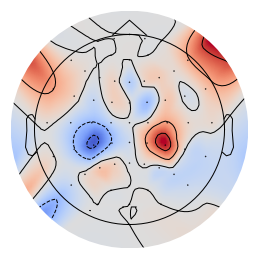

-----------RIGHT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


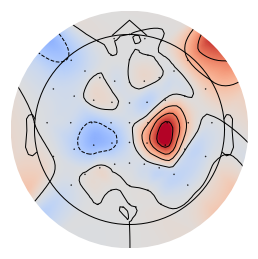

-----------RIGHT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


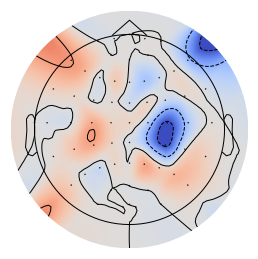

-----------LEFT-----------
0
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


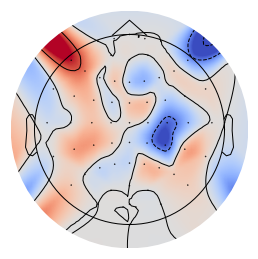

-----------LEFT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


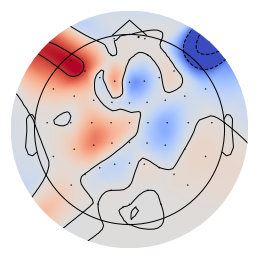

-----------LEFT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


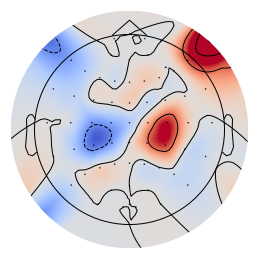

-----------RIGHT-----------
0
0
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


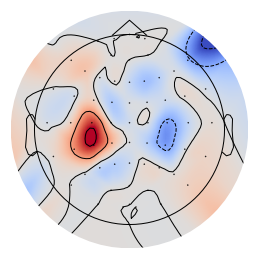

-----------LEFT-----------
0
0
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


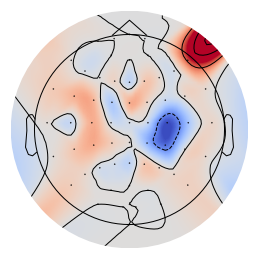

-----------LEFT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


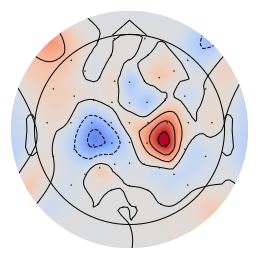

-----------RIGHT-----------
0
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


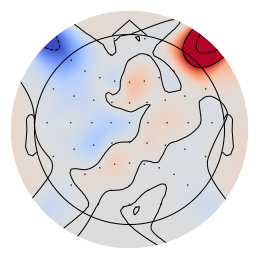

-----------RIGHT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


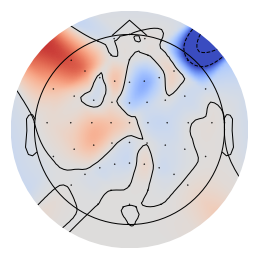

-----------LEFT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


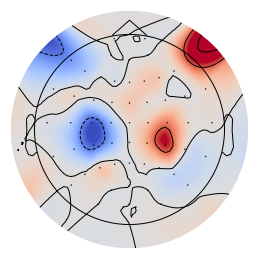

-----------RIGHT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


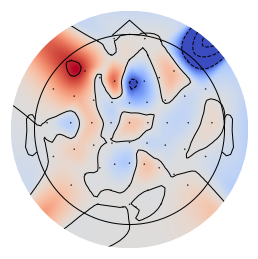

-----------LEFT-----------
0
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


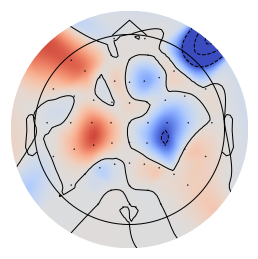

-----------LEFT-----------
0
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


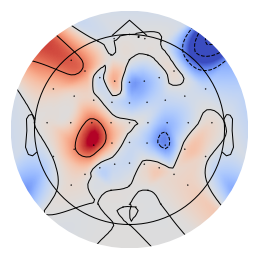

-----------LEFT-----------
0
0
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


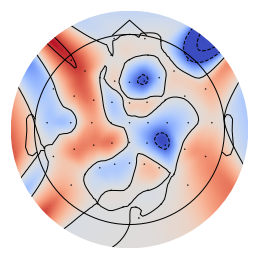

-----------LEFT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


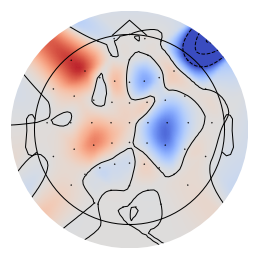

-----------LEFT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


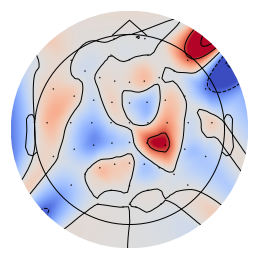

-----------RIGHT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


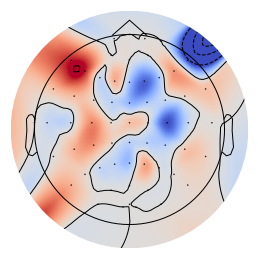

-----------LEFT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


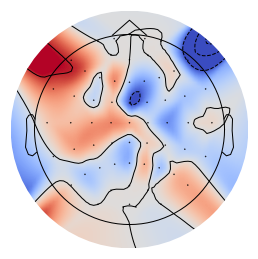

-----------LEFT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


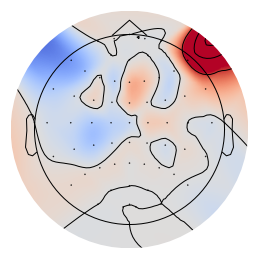

-----------RIGHT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


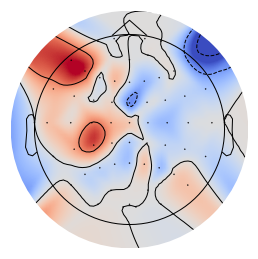

-----------LEFT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


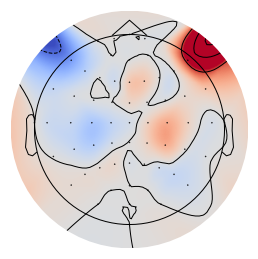

-----------RIGHT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


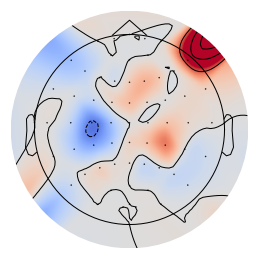

-----------RIGHT-----------
0
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


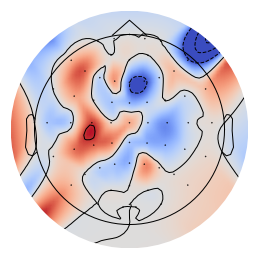

-----------LEFT-----------
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


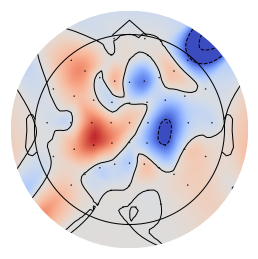

-----------LEFT-----------
0
0
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


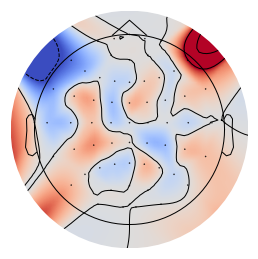

-----------LEFT-----------
0
0
0
0


/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/dwang/anaconda3/envs/Brain_Decoder/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [56]:
R_for_Left = []
R_for_Right = []
flag = 0
tmp = []

zeros = np.float32(np.zeros((1,1,387,1)))
ones = np.float32(np.ones((1,1,387,1)))
mask_for_class_left = np_to_var(np.concatenate((ones,zeros), axis=1)).cuda()
mask_for_class_right = np_to_var(np.concatenate((zeros,ones), axis=1)).cuda()

for i in range(test_X.shape[0]):
    trail_num = i
    
    data = test_X[trail_num, :, :]
    data.shape = (1, 64, 496, 1)
    data = np_to_var(data).cuda()

    label = test_y[trail_num]
    
    # 为每个前向过程存储各个层的输入和输出
    layer_outputs = []
    layer_inputs = []
    
    # Forward
    Predict_movement = MotioNet(data)

    # Total relevance before softmax
    Total_R_Before_Softmax = layer_outputs[28]
 
    # the prediction of the forward process
    prediction = np.mean(var_to_np(Predict_movement), axis=1)
    tmp.append(prediction)
    
    if prediction[0] > prediction[1]:  # Predition is Left
        if label == 0:                 # Label is Left
            # 我们只将关于左手的、softmax输入的值做回传处理，关于右手的置0
            Total_R_Before_Softmax = Total_R_Before_Softmax*mask_for_class_left
            
            # Reverse
            Relevance_for_1_case = var_to_np(MotioNet.relprop(Total_R_Before_Softmax))
            # 对Input relevance在时间域做平均
            spatial_LRP_map = np.mean(Relevance_for_1_case, axis=2)[0,0,:]
            
            # 加入没有采用的channel，对应的LRP值为0
            spatial_LRP_map_new = np.concatenate((spatial_LRP_map, zero_channels))
            
            fig, ax = plt.subplots()
    
            mne.viz.plot_topomap(spatial_LRP_map_new, 
                                 positions,
                                 contours=6,
                                 cmap=cm.coolwarm,
                                 outlines='skirt',
                                 show=True)
        
            flag = np.sum(np.isnan(spatial_LRP_map_new).reshape(64))
            # 检查Relevance_for_1_case有没有nan，让所有bool类型的元素相加，flag=0表示没有
            if flag == 0:
                fig.savefig('LRP_maps_for_Beta1/Correct_Left_Prediction/'+ str(i)+'.png')
                R_for_Left.append(Relevance_for_1_case)
                print('-----------LEFT-----------')
            
    if prediction[0] < prediction[1]:  # Predition is Right
        if label == 1:                 # Label is Right
            Total_R_Before_Softmax = Total_R_Before_Softmax*mask_for_class_right
            
            # Reverse
            Relevance_for_1_case = var_to_np(MotioNet.relprop(Total_R_Before_Softmax))
            # 对Input relevance在时间域做平均
            spatial_LRP_map = np.mean(Relevance_for_1_case, axis=2)[0,0,:]
            
            # 加入没有采用的channel，对应的LRP值为0
            spatial_LRP_map_new = np.concatenate((spatial_LRP_map, zero_channels))
            
            fig, ax = plt.subplots()
    
            mne.viz.plot_topomap(spatial_LRP_map_new, 
                                 positions,
                                 contours=6,
                                 cmap=cm.coolwarm,
                                 outlines='skirt',
                                 show=True)
        
            flag = np.sum(np.isnan(spatial_LRP_map_new).reshape(64))
            # 检查Relevance_for_1_case有没有nan，让所有bool类型的元素相加，flag=0表示没有
            if flag == 0:
                fig.savefig('LRP_maps_for_Beta1/Correct_Right_Prediction/'+ str(i)+'.png')
                R_for_Right.append(Relevance_for_1_case)
                print('-----------RIGHT-----------')           
    print(flag)

---

## Averaged decision-making heatmap for each class

## Left hand imagination

In [57]:
ave_LRP_for_correct_left_preds = np.mean(np.concatenate(R_for_Left,axis=2),axis=2)[0,0,:]
zero_channels = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,
                          0.,0.,0.,0.,0.,0.,0.,0.,0.,])
ave_LRP_for_correct_left_preds = np.concatenate((ave_LRP_for_correct_left_preds, zero_channels))

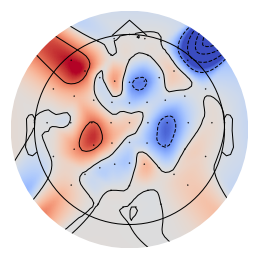

(<matplotlib.image.AxesImage at 0x7f820eee5fd0>,
 <matplotlib.contour.QuadContourSet at 0x7f820eee5b70>)

In [58]:
mne.viz.plot_topomap(ave_LRP_for_correct_left_preds, 
                     positions,
                     contours=8,
                     cmap=cm.coolwarm,
                     outlines='skirt',
                     show=True)

In [59]:
ave_LRP_for_correct_right_preds = np.mean(np.concatenate(R_for_Right,axis=2),axis=2)[0,0,:]
zero_channels = np.array([0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,
                          0.,0.,0.,0.,0.,0.,0.,0.,0.,])
ave_LRP_for_correct_right_preds = np.concatenate((ave_LRP_for_correct_right_preds, zero_channels))

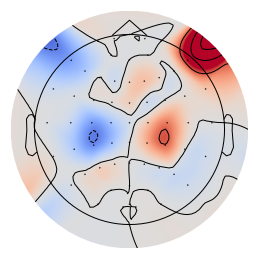

(<matplotlib.image.AxesImage at 0x7f820ee52fd0>,
 <matplotlib.contour.QuadContourSet at 0x7f820ee52be0>)

In [60]:
mne.viz.plot_topomap(ave_LRP_for_correct_right_preds, 
                     positions,
                     contours=8,
                     cmap=cm.coolwarm,
                     outlines='skirt',
                     show=True)

In [61]:
R_for_Left = np.concatenate(R_for_Left, axis=0)  # R_for_Left.shape = (batch, 1, 496, 45)

In [62]:
R_for_Right = np.concatenate(R_for_Right, axis=0)

In [63]:
#scipy.io.savemat('LRP_Heatmaps_Matlab_Array/LRP_maps_for_Right.mat', mdict={'LRP_maps_for_Right': R_for_Right})
#scipy.io.savemat('LRP_Heatmaps_Matlab_Array/LRP_maps_for_Left.mat', mdict={'LRP_maps_for_Left': R_for_Left})
scipy.io.savemat('LRP_Heatmaps_Matlab_Array/Ave_LRP_for_TestParticipant'+str(Test_participant_Num-64)+'_Right.mat', mdict={'Ave_LRP_map_for_Right': ave_LRP_for_correct_right_preds})
scipy.io.savemat('LRP_Heatmaps_Matlab_Array/Ave_LRP_for_TestParticipant'+str(Test_participant_Num-64)+'_Left.mat', mdict={'Ave_LRP_map_for_Left': ave_LRP_for_correct_left_preds})